In [11]:
%reset -f

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

data = pd.read_csv("dataset_part_2.csv")
X = pd.read_csv("dataset_part_3.csv")
Y = pd.Series(data['Class']).to_numpy()
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2, stratify=Y)

#Define the hyperparameters to search over for each model
logreg_params = {'C':[0.01,0.1,1],
                'penalty':['l2'],
                'solver':['lbfgs']}

svm_params = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
                'C': np.logspace(-3, 3, 5),
                'gamma':np.logspace(-3, 3, 5)}

tree_params = {'criterion': ['gini', 'entropy'],
                'splitter': ['best', 'random'],
                'max_depth': [2*n for n in range(1,10)],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 5, 10]}

knn_params = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                'p': [1,2]}

params = {'LOGREG': logreg_params, 'SVM': svm_params, 'TREE': tree_params, 'KNN': knn_params}

#Initialize the models
logreg = LogisticRegression(random_state=2)
svm = SVC(random_state=2)
tree = DecisionTreeClassifier(random_state=2)
knn = KNeighborsClassifier()

#Train the models on the training data X_train, X_test, Y_train, Y_test
logreg.fit(X_train, Y_train)
svm.fit(X_train, Y_train)
tree.fit(X_train, Y_train)
knn.fit(X_train, Y_train)

#Create a dictionary of the trained models
models = {'LOGREG': logreg, 'SVM': svm, 'TREE': tree, 'KNN': knn}

#Initialize empty lists to store the metrics for each model
precision = {
    'Model': [],
    'precision (train)': [],
    'recall (train)': [],
    'f1-score (train)': [],
    'precision (test)': [],
    'recall (test)': [],
    'f1-score (test)': []
    }

metric = 'weighted avg'

for model_name, model in models.items():
    try:
        #Create the GridSearchCV object for this model
        grid = GridSearchCV(model, params[model_name], cv=10)
        #Fit the GridSearchCV object to the training data
        grid.fit(X_train, Y_train)

        #Use the best estimator to make predictions on the training and test data
        train_preds = grid.best_estimator_.predict(X_train)
        test_preds = grid.best_estimator_.predict(X_test)

        #Evaluate the performance on the training and test data using the classification_report
        train_report = classification_report(Y_train, train_preds, output_dict=True)
        test_report = classification_report(Y_test, test_preds, output_dict=True)

        #Extract the precision, recall, and f1-score from the train_report and test_report
        precision['precision (train)'].append(train_report[metric]['precision'])
        precision['recall (train)'].append(train_report[metric]['recall'])
        precision['f1-score (train)'].append(train_report[metric]['f1-score'])
        precision['precision (test)'].append(test_report[metric]['precision'])
        precision['recall (test)'].append(test_report[metric]['recall'])
        precision['f1-score (test)'].append(test_report[metric]['f1-score'])

        precision['Model'].append(model_name)

    except Exception as e:
        print(f"Model {model_name} failed to converge during training: {e}")

#Create result table
precision_df = pd.DataFrame(precision)

In [ ]:
%matplotlib inline
#Plot all metrics in a bar graph
x = np.arange(len(precision['Model']))
width = 0.1
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision['precision (train)'], width, label='Train Precision')
rects2 = ax.bar(x,  precision['recall (train)'], width, label='Train Recall')
rects3 = ax.bar(x + width, precision['f1-score (train)'], width, label='Train F1-score')
rects4 = ax.bar(x + 2*width,  precision['precision (test)'], width, label='Test Precision')
rects5 = ax.bar(x + 3*width,  precision['recall (test)'], width, label='Test Recall')
rects6 = ax.bar(x + 4*width, precision['f1-score (test)'], width, label='Test F1-score')
ax.set_xticks(x)
ax.set_xticklabels(precision['Model'])
ax.legend()
plt.show()

# Discussion

The table shows the performance of four different classification models (Logistic Regression, Support Vector Machine, Decision Tree, and K-Nearest Neighbors) on a binary classification problem. The models were evaluated on both training and test sets using precision, recall, and F1-score metrics, with a weighted average used to account for class imbalance.

Looking at the training metrics, all models have high precision, recall, and F1-score values, indicating good performance on the training set. However, the test metrics show a drop in performance for all models, with the F1-scores decreasing by more than 20% in some cases.

The Logistic Regression and SVM models have similar performance on both training and test sets, with F1-scores of 0.764. The Decision Tree model has a lower F1-score of 0.675 on the test set, indicating that it may be overfitting to the training data. The K-Nearest Neighbors model has a higher F1-score of 0.764 on the test set, but its training metrics are lower than those of the other models, indicating that it may not be as effective at capturing the underlying patterns in the data.

Model | precision (train) | recall (train) | f1-score (train) | precision (test) | recall (test) | f1-score (test)
--- | --- | --- | --- | --- | --- | ---
LOGREG | 0.986395 | 0.986111 | 0.986035 | 0.77381 | 0.777778 | 0.764103
SVM | 0.973333 | 0.972222 | 0.971902 | 0.77381 | 0.777778 | 0.764103
TREE | 0.947046 | 0.944444 | 0.944965 | 0.70000 | 0.666667 | 0.675325
KNN | 0.851693 | 0.847222 | 0.839372 | 0.77381 | 0.777778 | 0.764103

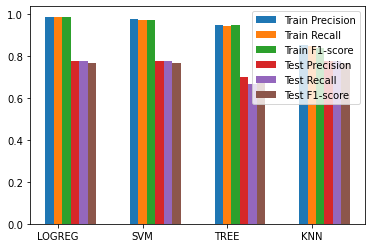

**CONCLUSION**: 
Overall, the results suggest that the Logistic Regression and SVM models are the most effective at classifying the data, as they have the highest F1-scores on the test set. However, further analysis would be needed to determine if one model is significantly better than the others or if any additional feature engineering or model tuning is necessary to improve performance.


_Andreas Petker, 17. February 2023_